# **Sentimental Analysis on IMDB Movie Reviews**

In [55]:
# Imports
import re
import numpy as np
from os import listdir
from collections import Counter
import spacy
from random import shuffle

from keras.preprocessing.text import Tokenizer
from keras import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model

nlp = spacy.load("en_core_web_sm")

# Drive root dir for data files
drive_root = '/content/drive/MyDrive/NLP-In-Depth/Develop Deep Learning Models for Natural Language in Python/Data/txt_sentoken'

## Data PrePreprocessing 

### Feature Extraction - Load & Clean

In [ ]:
def load_doc(path):
  ''' Loads a document given its path and returns the content '''

  with open(path, 'r') as reader:
    doc = reader.read()
  return doc


def clean_doc(doc):
  ''' Returns the cleaned form of a given doc '''

  doc = nlp(doc)

  # Filter punctuations, stopwords and lemmatize
  doc = ' '.join([token.lemma_ for token in doc if (not token.is_punct) and (not token.is_stop)])

  # Filter non-alphabetic, one-characters
  tokens = [word for word in doc.split(' ') if word.isalpha() and len(word) > 1]

  return tokens


def load_docs(root_dir, sub_folder, vocab):
  ''' Loads all the documents within the path and returns the cleaned form '''

  dir = root_dir + '/' + sub_folder
  docs = []

  for filename in listdir(dir):

    print(f'Processing {sub_folder} document \'{filename}\'...')

    # Load doc
    doc = load_doc(dir + '/' + filename)

    # Clean doc
    tokens = clean_doc(doc)

    # Update vocabulary
    vocab.update(tokens)

    # Add to docs
    docs.append(' '.join(tokens))    

  return docs

In [ ]:
# Construct counter object
vocab = Counter()

# Load positive reviews
pos_docs = load_docs(drive_root, 'pos', vocab)

# Load negative reviews
neg_docs = load_docs(drive_root, 'neg', vocab)

print('Vocab size:', len(vocab))
print('50 Most common words:', vocab.most_common(50))

Processing pos document 'cv000_29590.txt'...
Processing pos document 'cv001_18431.txt'...
Processing pos document 'cv002_15918.txt'...
Processing pos document 'cv003_11664.txt'...
Processing pos document 'cv004_11636.txt'...
Processing pos document 'cv005_29443.txt'...
Processing pos document 'cv006_15448.txt'...
Processing pos document 'cv007_4968.txt'...
Processing pos document 'cv008_29435.txt'...
Processing pos document 'cv009_29592.txt'...
Processing pos document 'cv010_29198.txt'...
Processing pos document 'cv011_12166.txt'...
Processing pos document 'cv012_29576.txt'...
Processing pos document 'cv013_10159.txt'...
Processing pos document 'cv014_13924.txt'...
Processing pos document 'cv015_29439.txt'...
Processing pos document 'cv016_4659.txt'...
Processing pos document 'cv017_22464.txt'...
Processing pos document 'cv018_20137.txt'...
Processing pos document 'cv019_14482.txt'...
Processing pos document 'cv020_8825.txt'...
Processing pos document 'cv021_15838.txt'...
Processing po

### More Work on Vocab

In [ ]:
def filter_docs(docs, vocab_words):
  ''' Filters tokens in given text by vocabulary '''

  for i in range(len(docs)):
    docs[i] = ' '.join([token for token in docs[i].split(' ') if token in vocab_words])
  return docs


# Remove least frequently used words
min_occurance = 2
vocab_words = [key for key, count in vocab.items() if count >= min_occurance]

# Fitler docs
pos_docs = filter_docs(pos_docs, vocab_words)
neg_docs = filter_docs(neg_docs, vocab_words)

### Save Cleaned Docs & Vocab

In [47]:
# Save Vocab for future use
with open(drive_root + '/vocab.txt', 'w') as writer:
  writer.write('\n'.join(vocab_words))

# Save positive docs
with open(drive_root + '/pos.txt', 'w') as writer:
  writer.write('\n'.join(pos_docs))

# Save negative docs
with open(drive_root + '/neg.txt', 'w') as writer:
  writer.write('\n'.join(neg_docs))

## Sentimental Analysis

### Load saved data

In [48]:
# Save Vocab for future use
with open(drive_root + '/vocab.txt', 'r') as reader:
  vocab = reader.read().split('\n')

# Save positive docs
with open(drive_root + '/pos.txt', 'r') as reader:
  pos_docs = reader.read().split('\n')

# Save negative docs
with open(drive_root + '/neg.txt', 'r') as reader:
  neg_docs = reader.read().split('\n')

### Split data

In [50]:
def split(pos_docs, neg_docs, test_size = 200):
  ''' Splits the docs into training and test sets '''

  split = test_size // 2

  # Unite pos_docs & neg_docs and corresponding labels
  docs = pos_docs + neg_docs
  labels = [1 for _ in range(len(pos_docs))] + [0 for _ in range(len(neg_docs))]

  # Convert into tuple
  data = [(docs[i], labels[i]) for i in range(len(docs))]

  # Split data into train & test sets
  train_data = data[split:-split]
  test_data = data[:split] + data[-split:]

  # Shuffle data
  shuffle(train_data)
  shuffle(test_data)

  return train_data, test_data

train_data, test_data = split(pos_docs, neg_docs, test_size = 200)

### Tokenize data

In [62]:
def create_tokenizer(vocab):
  ''' Creates, fits and returns a tokenizer '''

  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(vocab)
  return tokenizer

tokenizer = create_tokenizer(vocab)

# Get texts
train_texts = [text for (text, label) in train_data]
test_texts = [text for (text, label) in test_data]

# Get labels
y_train = np.array([label for (text, label) in train_data])
y_test = np.array([label for (text, label) in test_data])

X_train = tokenizer.texts_to_matrix(train_texts, mode = 'freq')
X_test = tokenizer.texts_to_matrix(test_texts, mode = 'freq')

print('Dimentions:', X_train.shape, X_test.shape)

Dimentions: (1800, 20000) (200, 20000)


### Build the Model

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 50)                1000050   
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 51        
Total params: 1,000,101
Trainable params: 1,000,101
Non-trainable params: 0
_________________________________________________________________


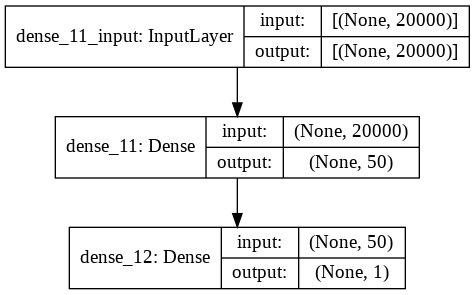

In [76]:
model = Sequential()

input_shape = X_train.shape[1]

# Add layers
model.add(Dense(units = 50, input_shape = (input_shape, ), activation = 'relu'))
model.add(Dense(units = 1, activation = 'sigmoid'))

# Compile and summerize
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()
plot_model(model, show_shapes = True)

In [77]:
# Fit the model
model.fit(X_train, y_train, epochs = 10, verbose = 2)

Epoch 1/10
57/57 - 1s - loss: 0.6912 - accuracy: 0.5667
Epoch 2/10
57/57 - 0s - loss: 0.6800 - accuracy: 0.8033
Epoch 3/10
57/57 - 1s - loss: 0.6591 - accuracy: 0.8844
Epoch 4/10
57/57 - 0s - loss: 0.6268 - accuracy: 0.9050
Epoch 5/10
57/57 - 0s - loss: 0.5864 - accuracy: 0.9233
Epoch 6/10
57/57 - 0s - loss: 0.5409 - accuracy: 0.9300
Epoch 7/10
57/57 - 1s - loss: 0.4941 - accuracy: 0.9394
Epoch 8/10
57/57 - 0s - loss: 0.4505 - accuracy: 0.9367
Epoch 9/10
57/57 - 1s - loss: 0.4058 - accuracy: 0.9522
Epoch 10/10
57/57 - 0s - loss: 0.3656 - accuracy: 0.9578


In [81]:
# Evaluate Model
loss, acc = model.evaluate(X_test, y_test, verbose = 2)
print(f'Accuracy: {round(acc * 100, 2)}%')
print(f'Loss: {round(loss * 100, 2)}%')

7/7 - 0s - loss: 0.4843 - accuracy: 0.8250
Accuracy: 82.5%
Loss: 48.43%
